<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 0 - Introducción a Redes Neuronales </H3>
<div align='center'>
###  Felipe González - 201273534-3 
### Ignacio Tampe - 201573514-k 
</div>
<hr style="height:2px;border:none"/>

## Importe de Librerías necesarias para toda la tarea

In [1]:
import numpy as np
import random
import time
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import keras
%matplotlib inline

Using TensorFlow backend.


## 1. Back-propagation (BP) from *Scratch*

Para la realización de la primera parte de la tarea, se implementó una clase red neuronal basada en SGD con activación de la última capa con softmax, la cual permite mayor modularización su estructura, tanto en tamaño y cantidad de capas, como en la función de activación y costo de ésta.

Así se crearon las clases: RedNeuronal, CapaNeuronal y Neurona.

Para instanciar una red neuronal se realiza de la siguiente forma:
```python
nn = RedNeuronal(num_entrada, tam_capas, num_salida, act_inter, cost_func)
```
Donde los parámetros son:
>* **num_entrada**: dimension de los vectores de entrada.
>* **tam_capas**: lista de cantidad de neuronas por cada capa interna, [32, 16], también indica la cantidad de capas internas.
>* **num_salida**: dimension de los vectores de salida.
>* **act_inter**: función de activación de capas internas: "sigmoid" / "relu" / "arctan" / "softmax".
>* **cost_func**: función de costo: "crossentropy" / "mse".

La implementación que incluye *Forward pass*, *Backward pass* y rutina de entretamiento se encuentra a continuación.

Tanto *Forward pass* y *Backward pass* están implementados dentro del método correspondiente a la rutina de entrenamiento.

In [2]:
class RedNeuronal:
    
    # num_entrada: dimension de los vectores de entrada, en iris: 4
    # tam_capas: lista de cantidad de neuronas por cada capa interna, en iris: [32, 16]
    # num_salida: dimension de los vectores de salida, en iris: 3
    # act_inter: función de activación de capas internas: "sigmoid" / "relu" / "arctan" / "softmax"
    # cost_func: función de costo: "crossentropy" / "mse" 
    def __init__(self, num_entrada, tam_capas, num_salida, act_inter, cost_func):
        self.num_entrada = num_entrada
        self.tam_capas = tam_capas
        self.num_salida = num_salida
        self.capas = []
        self.log = dict()
        # iniciar todas las capas inicial - ocultas - final
        self.capas.append(CapaNeuronal(num_entrada, act_inter))
        for i in range(len(tam_capas)):
            self.capas.append(CapaNeuronal(tam_capas[i], act_inter, self.capas[i].tam_capa))
        self.capas.append(CapaNeuronal(num_salida, "softmax", self.capas[len(self.capas)-1].tam_capa))
        self.cant_capas = len(self.capas)
        if cost_func == "crossentropy":
            self.cost = self.crossentropy
            self.cost_derivative = self.crossentropy_derivative
        elif cost_func == "mse":
            self.cost = self.mse
            self.cost_derivative = self.mse_derivative
        print("Red Neuronal creada")
        print("\tCapas:", num_entrada, tam_capas, num_salida)
        print("\tActivación interna:", act_inter)
        print("\tFunción de costo:", cost_func)

    def crossentropy(self, prediccion, esperado, epsilon=1e-12): #El epsilon evita log(0)
        prediccion = np.clip(prediccion, epsilon, 1. - epsilon)
        N = prediccion.shape[0]
        ce = -np.sum(np.sum(esperado*np.log(prediccion+epsilon)))/N
        return ce
    
    def crossentropy_derivative(self, prediccion, esperado, squash_prime, vector_z):
        return prediccion-esperado

    def mse(self, prediccion, esperado):
        return 0.5*np.dot(prediccion-esperado, prediccion-esperado)
    
    def mse_derivative(self, prediccion, esperado, squash_prime, vector_z):
        return (prediccion-esperado) * squash_prime(vector_z)
    
    # train(entrada, salida, ciclos, tasa):
    # entrada: lista de datos de entrada.
    # salida: lista de vectores de salida tipo onehot.
    # ciclos: cantidad de epochs.
    # tasa: tasa de aprendizaje .
    # verbose: Booleano que indica progreso por epoch o solo el final.
    # momentum: agrega la posibilidad de entrenar con momentum, recibe el valor de éste.
    def train(self, entrada, salida, ciclos, tasa, verbose = False, momentum = None):
        last = self.cant_capas-1 # indice capa de salida
        result = zip(entrada,salida)
        resultList = list(result)
        loss = []
        accuracy = []
        tiempo = []
        print("Comienza entrenamiento de red", end=" ")
        if momentum:
            print("con momentum", momentum)
        else:
            print()
        for ciclo in range(ciclos):
            # Comienza 1 epoch
            random.shuffle(resultList)
            errores = []
            acertados = 0
            primera_iter = True
            lista_delta_pesos = list(np.zeros(self.cant_capas))
            start = time.time()
            for input_v, output in resultList:
                #Poblar capa inicial
                self.capas[0].set_capa(input_v, input_v) 
                
                # Feed forward 
                for j in range(1, len(self.capas)):
                    self.capas[j].feed_forward(self.capas[j-1])
                
                # evaluar error final (delta función costo)
                prediccion = self.capas[last].get_activaciones()
                error_epoch = self.cost(self.capas[last].get_activaciones(), output)
                errores.append(error_epoch)
                
                if (np.argmax(prediccion) == np.argmax(output)):
                    acertados += 1
                
                #Backward pass capa final
                delta = self.cost_derivative(prediccion, np.transpose(output), self.capas[last].squash_derivative, self.capas[last].get_vector_z())
                
                self.capas[last].actualizar_bias(delta, tasa)
                
                delta_peso = np.outer(self.capas[last-1].get_activaciones(), delta)
                
                if momentum:
                    if primera_iter:
                        self.capas[last].actualizar_pesos(delta_peso, tasa)
                    else:
                        self.capas[last].actualizar_pesos_momentum(delta_peso, tasa, momentum, lista_delta_pesos[last])
                    lista_delta_pesos[last] = tasa*delta_peso
                else:
                    self.capas[last].actualizar_pesos(delta_peso, tasa)
                #Backward pass general
                for l in range(2, self.cant_capas):
                    z = self.capas[-l].get_vector_z()
                    act_prime = self.capas[-l].squash_derivative(z)
                    delta = np.dot(self.capas[-l+1].get_pesos(), delta.transpose()) * act_prime
                    delta_peso = np.outer(self.capas[-l-1].get_activaciones(),delta)
                    
                    self.capas[-l].actualizar_bias(delta, tasa)
                    if momentum:
                        if primera_iter:
                            self.capas[-l].actualizar_pesos(delta_peso, tasa)
                        else:
                            self.capas[-l].actualizar_pesos_momentum(delta_peso, tasa, momentum, lista_delta_pesos[-l])
                        #Actualizacion de lista de pesos
                        lista_delta_pesos[-l] = np.outer(self.capas[-l-1].get_activaciones(), delta)
                    else:
                        self.capas[-l].actualizar_pesos(delta_peso, tasa)
                        
                primera_iter = True
            loss.append(np.mean(errores))
            accuracy.append(acertados/len(resultList))
            tiempo.append(time.time()-start)
            primera_ter = False
            if verbose:
                print("\tError del epoch "+str(ciclo)+": loss", str(np.round(np.mean(errores),5)),"- acc", acertados/len(resultList))
        print("Resultado de training set de", ciclos,"epochs: loss", np.mean(errores),"- acc:", acertados/len(resultList))
        self.log['loss'] = loss
        self.log['accuracy'] = accuracy
        self.log['tiempo'] = tiempo

    # test(entrada, salida):
    # entrada: lista de datos de entrada de test.
    # salida: Lista de datos esperados de test, en formato onehot vector.
    # retorna listas de predicciones y valores esperados.
    def test(self, entrada, salida):
        # repetir para todas 
        last = self.cant_capas-1 # indice capa de salida
        result = zip(entrada,salida)
        resultList = list(result)
        errores = []
        acertados = 0
        lista_pred = []
        lista_res = []
        for input_v, output in resultList:
            self.capas[0].set_capa(input_v, input_v) #Poblar capa inicial
            # Feed forward 
            for j in range(1, len(self.capas)):
                self.capas[j].feed_forward(self.capas[j-1])

            
            prediccion = self.capas[last].get_activaciones()
            
            if (np.argmax(prediccion) == np.argmax(output)):
                    acertados += 1
            lista_pred.append(np.argmax(prediccion))
            lista_res.append(np.argmax(output))
            # evaluar error final (delta función costo)
            error_epoch = self.crossentropy(prediccion, output)
            errores.append(error_epoch)
        
        print("Error del test: loss", str(np.round(np.mean(errores),5)),"- acc", acertados/len(resultList))
        return lista_pred, lista_res
    
    # predict(entrada, categorias):
    # entrada: Vector de entrada para predecir
    # categorias: Etiquetas correspondientes a las categorias
    # retorna la etiqueta correspondiente a la predicción de la red neuronal 
    def predict(self, entrada, categorias):
        last = self.cant_capas-1
        self.capas[0].set_capa(entrada, entrada)
        
        for j in range(1, len(self.capas)):
                self.capas[j].feed_forward(self.capas[j-1])
        
        prediccion = self.capas[last].get_activaciones()
        
        return categorias[np.argmax(prediccion)]

In [3]:
class CapaNeuronal:
    def __init__(self, tam_capa, tipo, tam_anterior = 0):
        self.tam_capa = tam_capa
        self.tam_anterior = tam_anterior
        self.bias = 1
        self.neuronas = [Neurona(tam_anterior) for i in range(tam_capa)] # lista de neuronas de la capa
        if tipo == "sigmoid":
            self.squash = self.sigmoid
            self.squash_derivative = self.sigmoid_derivative
        elif tipo == "softmax":
            self.squash = self.softmax
            self.squash_derivative = self.softmax_derivative
        elif tipo == "arctan":
            self.squash = self.arctan
            self.squash_derivative = self.arctan_derivative
        elif tipo == "relu":
            self.squash = self.relu
            self.squash_derivative = self.relu_derivative
       
    def sigmoid(self, x):
        return np.array([np.where(i > 0, 1. / (1. + np.exp(-i)), np.exp(i) / (np.exp(i) + np.exp(0))) for i in x])
    
    def sigmoid_derivative(self, x):
        return np.multiply(self.sigmoid(x),(1-self.sigmoid(x)))
    
    def arctan(self, x):
        return np.arctan(x)
    
    def arctan_derivative(self, x):
        return np.power(np.cos(x),2)
        
    def relu(self, x):
        x= np.array(x)
        return np.maximum(x, 0, x)
    
    def relu_derivative(self, x):
        x = np.array(x)
        return (x > 0).astype(int)
    
    def softmax(self, x):
        X = np.clip(x,-350,350)
        x = np.exp(x-np.max(x))
        return x / np.sum(x, axis=0)
    
    def softmax_derivative(self, x):
        x = np.clip(x, -350, 350)
        res = []
        for i in x:
            res.append(np.exp(i)*(np.sum(np.exp(x), axis=0)-np.exp(i))/(np.sum(np.exp(x), axis=0)**2))
        #print(x)
        return np.array(res)
    
    def get_activaciones(self):
        return np.array([neurona.activacion for neurona in self.neuronas])
    
    def get_vector_z(self):
        return [neurona.z for neurona in self.neuronas]
    
    
    def feed_forward(self, capa_anterior):
        pre_squash = []
        activaciones = capa_anterior.get_activaciones()
        vector_z = capa_anterior.get_vector_z()
        for neurona in self.neuronas:
            pesos = neurona.pesos
            pre_squash.append(np.dot(pesos, activaciones) + neurona.bias)
        self.set_capa(self.squash(pre_squash), pre_squash)
   
    def get_pesos(self):
        return np.transpose(np.array([n.pesos for n in self.neuronas]))

    def actualizar_pesos(self, matriz, rate, momentum = 0, prev_delta_pesos = 0):
        pesos = np.transpose(np.array([n.pesos for n in self.neuronas]))
        pesos -= rate*matriz + momentum*prev_delta_pesos
        for i in range(len(self.neuronas)):
            self.neuronas[i].pesos = pesos[:,i]
    
    def actualizar_bias(self, vector_b, rate):
        biases = np.array([n.bias for n in self.neuronas])
        biases -= rate*vector_b #SE PUSO SUMA PORQUE BAJABA EL ERROR DEL EPOCH
        for i in range(len(self.neuronas)):
            self.neuronas[i].bias = biases[i]
    
    #Funcion para poblar datos de entrada a la red.
    def set_capa(self, activaciones, vector_z):
        for i in range(len(self.neuronas)):
            self.neuronas[i].set_activacion(activaciones[i], vector_z[i])
            
    def mostrar_capa(self):
        for neurona in self.neuronas:
            print(neurona, end="\t")
        print("\n-----------------------------")

        
class Neurona:
    def __init__(self, tam_capa_anterior):
        self.pesos = np.random.rand(tam_capa_anterior) # genera una lista de numeros aleatorios de tamaño "tam_capa_anterior"
        self.bias = np.random.rand()
        
    def set_activacion(self, valor_a, valor_z):
        self.activacion = valor_a
        self.z = valor_z
        
    def __str__(self):
        return "Activación: "+str(self.activacion)

Para poder probar el funcionamiento de la red neuronal se debe instanciar y llamar al método en entrenamiento de la siguiente forma:

```python
nn.train(entrada, salida, ciclos, tasa)
```

>* **entrada**: lista de datos de entrada.
>* **salida**: lista de vectores de salida tipo onehot.
>* **ciclos**: cantidad de epochs.
>* **tasa**: tasa de aprendizaje .
>* **verbose**: Booleano que indica progreso por epoch o solo el final. (keyword argument, Default: False)

Esta función tomará el dataset entregado y ejecutará una rutina de Feed Forward -> Cálculo de error -> Backpropagation por la cantidad de ciclos necesaria, mezclando en cada ciclo los datos de forma aleatoria para minimizar sesgo.

### 1.b) Predicciones utilizando feed forward

Una vez entrenada la red, se puede utilizar para realizar predicciones de la siguiente forma:
```python
categorias = ['setosa', 'versicolor', 'verginica']
for entrada in x_test:
    prediccion = nn.predict(entrada, categorias)
```
Esta función tomará una entrada e intentará realizar una predicción mediante *Feed Forward*, retornando la etiqueta correspondiente.

### 1.c) Probar la implementación en un problema de clasificación.

Para probar nuestra implementación de red neuronal se utliza el dataset iris el cual se normaliza y se separa en un *training set* y un *testing set*.

In [4]:
#Carga y estructuración de datos
x, y = load_iris(return_X_y=True)
scaler = StandardScaler().fit(x)
x = scaler.transform(x) 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=50)
y_onehot_train = keras.utils.to_categorical(y_train)
y_onehot_test = keras.utils.to_categorical(y_test)
tags = ['setosa', 'versicolor', 'verginica']

Con los datos cargados se procede a instanciar las 4 redes neuronales a evaluar, utilizando *sigmoid* o ReLU como función de activación y usando MSE o Cross Entropy como función de costo:

Las funciones de activación están implementadas dentro de la clase CapaNeuronal junto con sus derivadas.

Las funciones de costo están implementadas dentro de la clase RedNeuronal junto con sus derivadas.

In [5]:
# Instanciar redes neuronales
nn_sm = RedNeuronal(4, [32, 16], 3, "sigmoid", "mse")
nn_sc = RedNeuronal(4, [32, 16], 3, "sigmoid", "crossentropy")
nn_rm = RedNeuronal(4, [32, 16], 3, "relu", "mse")
nn_rc = RedNeuronal(4, [32, 16], 3, "relu", "crossentropy")

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: mse
Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: crossentropy
Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: relu
	Función de costo: mse
Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: relu
	Función de costo: crossentropy


Luego se procede a entrenar cada una de las redes con 100 *epochs* y un *learning rate* $\eta = 0.1$

Tras esto se extraen los datos del registro de entrenamiento:

In [6]:
#Entrenar la red 
nn_sm.train(x_train, y_onehot_train, 100, 0.1)
nn_sc.train(x_train, y_onehot_train, 100, 0.1)
nn_rm.train(x_train, y_onehot_train, 100, 0.1)
nn_rc.train(x_train, y_onehot_train, 100, 0.1)

loss_sm = nn_sm.log['loss']
accuracy_sm = nn_sm.log['accuracy']
tiempo_sm = nn_sm.log['tiempo']

loss_sc = nn_sc.log['loss']
accuracy_sc = nn_sc.log['accuracy']
tiempo_sc = nn_sc.log['tiempo']

loss_rm = nn_rm.log['loss']
accuracy_rm = nn_rm.log['accuracy']
tiempo_rm = nn_rm.log['tiempo']

loss_rc = nn_rc.log['loss']
accuracy_rc = nn_rc.log['accuracy']
tiempo_rc = nn_rc.log['tiempo']

Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.14318654394 - acc: 0.83
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.0312225990025 - acc: 0.97
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.66999809605 - acc: 0.33
Comienza entrenamiento de red 


C:\Users\gonza\AppData\Local\conda\conda\envs\redesneuronales\lib\site-packages\numpy\core\numeric.py:1154: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis,:], out)
C:\Users\gonza\AppData\Local\conda\conda\envs\redesneuronales\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in subtract
C:\Users\gonza\AppData\Local\conda\conda\envs\redesneuronales\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in maximum
C:\Users\gonza\AppData\Local\conda\conda\envs\redesneuronales\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater


Resultado de training set de 100 epochs: loss nan - acc: 0.33


Tras entrenar las redes, se procede a graficar la función objetivo "Loss" y la precisión de clasificación:

plt.figure(1, figsize=(15,8))
plt.subplot(221)
plt.plot(range(len(accuracy_sm)), accuracy_sm, label="Accuracy")
plt.plot(range(len(loss_sm)), loss_sm, label="Loss")
plt.legend()
plt.subplot(222)
plt.plot(range(len(accuracy_sc)), accuracy_sc, label="Accuracy")
plt.plot(range(len(loss_sc)), loss_sc, label="Loss")
plt.legend()
plt.subplot(223)
plt.plot(range(len(accuracy_rm)), accuracy_rm, label="Accuracy")
plt.plot(range(len(loss_rm)), loss_rm, label="Loss")
plt.legend()
plt.subplot(224)
plt.plot(range(len(accuracy_rc)), accuracy_rc, label="Accuracy")
plt.plot(range(len(loss_rc)), loss_rc, label="Loss")
plt.legend()
plt.show()

print("Tiempo total para activación sigmoid y costo MSE", round(np.sum(tiempo_sm),3))
print("Tiempo total para activación sigmoid y costo Cross Entropy", round(np.sum(tiempo_sc),3))
print("Tiempo total para activación ReLU y costo MSE", round(np.sum(tiempo_rm),3))
print("Tiempo total para activación ReLU y costo Cross Entropy", round(np.sum(tiempo_rc),3))

Se puede ver como la configuración Sigmoid y Cross-Entropy entrega resultados notoriamente mejores tanto para precisión de clasificación y minización de la función de pérdida, obteniéndose en algunos casos una accuracy cercana al 99%.

Además se desprende que la combinación ReLU y Cross Entropy es la más rápida, siendo cada una de estas la más rápida de su categoría (activación y costo) con un aumento de más de 4 veces la velocidad repecto a la configuración más lenta.

### Matriz de confusión para test con red de activación sigmoide y costo Cross-Entropy

Además de las funciones mencionadas previamente, se creó un método para hacer una rutina de testing y evaluar loss y accuracy con un dataset desconocido para la red neuronal:

```python
nn.test(entrada, salida)
```
Los parámetros de la función son
>* entrada: lista de datos de entrada de test
>* salida: Lista de datos esperados de test, en formato onehot vector

retorna listas de resultados predichos y esperados para poder realizar un análisis de confusión.

al probar esto se tiene:

Error del test: loss 0.07662 - acc 0.94
Normalized confusion matrix
[[ 1.          0.          0.        ]
 [ 0.          0.82352941  0.17647059]
 [ 0.          0.          1.        ]]


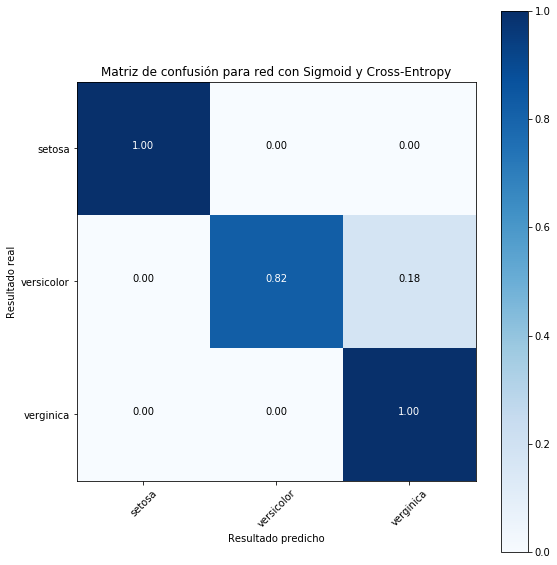

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Resultado real')
    plt.xlabel('Resultado predicho')
    
pred, real = nn_sc.test(x_test, y_onehot_test)
cnf_matrix = confusion_matrix(real, pred)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=tags, normalize=True,
                      title='Matriz de confusión para red con Sigmoid y Cross-Entropy')

De la matriz se desprende que solo un pequeño porcentaje del test falló, ya que la red predijo que era una planta del tipo "Verginica" cuadno en realidad era de tipo "Versicolor".

Fuera de esto, el resto de las predicciones no fallaron obteniéndose un 100% de precisión en algunos casos, como se ve en la diagonal de la matriz.

<a id="segundo"></a>
### 2. Comparar back-propagation (BP) de Keras

Keras es una de las librerı́as más populares para desarrollar nuevos modelos de redes neuronales o implementar eficientemente modelos conocidos con fines prácticos, puesto que ofrece una interfaz para poder trabajar de una manera mucho mas simple además de permitir también el manejo de configuraciones mas específicas.  

Como actividad pedagógica se comparó el algoritmo implementado en la sección anterior con el de alto nivel de la librería __[keras](https://keras.io/)__ . Se compararon los algoritmos sobre el mismo dataset con la misma arquitectura utilizada anteriormente, es decir, dos capas ocultas (con 32 y 16 neuronas respectivamente), 3 neuronas en la capa de salida con función de activación softmax, optimizador Descenso Gradiente Estocástico (SGD) con tasa de aprendizaje fija.

Utilizando la arquitectura definida anteriormente, se realizaron las comparaciones teniendo en cuenta las siguientes combinaciones de funciones de activación y de costo:
>* Sigmoid y Cross Entropy
>* Sigmoid y Median Squared Error
>* ReLU y Cross Entropy
>* ReLU y Median Squared Error

Los resultados fueron los siguientes:


### Red utilizando Sigmoid y Cross Entropy

a) Defina, a través de la interfaz de keras, la arquitectura de la red, con las funciones de activación para comparar con la sección anterior.

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense

In [9]:
model = Sequential()
model.add(Dense(32, input_dim=x_test.shape[1], activation="sigmoid"))
model.add(Dense(16, activation="sigmoid"))
model.add(Dense(3, activation="softmax"))

b) Defina, a través de la interfaz de keras, el optimizador de la red, en conjunto con la función de error, para poder comparar con la sección anterior.

In [10]:
from keras.optimizers import SGD

In [11]:
model.compile(optimizer=SGD(lr=0.1),loss="categorical_crossentropy", metrics=["accuracy"])

c) Entrene (ajuste) los pesos de la red definida mediante keras, reportando los mismos gráficos de la sección anterior para poder comparar. Si hay diferencias en la convergencia del algoritmo ¿A qué podría deverse? si hay una gran diferencia en los tiempos de entrenamiento ¿A qué podría deverse?

### Implementación con Keras

In [12]:
#Callback para medir los tiempos por epoch de keras
# Se utilizara en todas las combinaciones (sigmoid-cross entropy; sigmoid-mse, ReLu-cross entropy, ReLu-mse)
import time
class TimingCallback(keras.callbacks.Callback):
    def __init__(self):
        self.logs=[]
    def on_epoch_begin(self,epoch, logs={}):
        self.starttime=time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(time.time()-self.starttime)
    

In [13]:
#Numero de epochs que se utilizará en todas las combinaciones
num_epochs = 100

In [14]:
#Entrenamiento de red utilizando keras. Función activación:  sigmoide  Función de costo: cross entropy
tiempos_keras_sc = TimingCallback()
keras_sc = model.fit(x_train, y_onehot_train, epochs=num_epochs, batch_size=1, verbose=0, callbacks=[tiempos_keras_sc])
accuracy_keras_sc = keras_sc.history['acc']
loss_keras_sc = keras_sc.history['loss']

### Implementación Propia

In [15]:
nn_sc = RedNeuronal(4, [32, 16], 3, "sigmoid", "crossentropy")
nn_sc.train(x_train, y_onehot_train, num_epochs, 0.1, verbose = False)
loss_propia_sc = nn_sm.log['loss']
accuracy_propia_sc = nn_sm.log['accuracy']
tiempo_propia_sc = nn_sm.log['tiempo']

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: crossentropy
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.0294469344716 - acc: 0.97


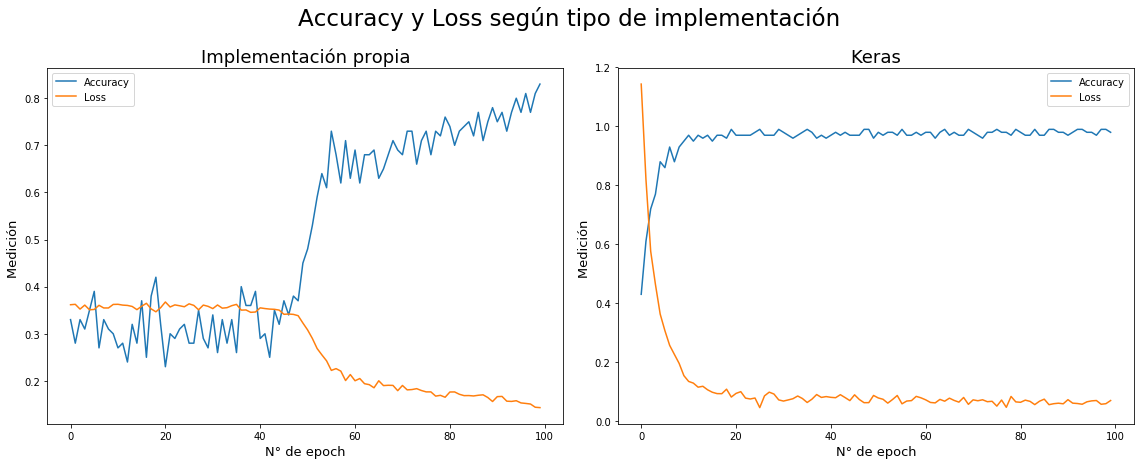



Accuracy Implementación Propia = 83.0%
Accuracy Keras = 98.0%


Loss Implementación Propia = 0.1432
Loss Keras = 0.0695


In [16]:

plt.figure(1, figsize=(16,6))
plt.suptitle("Accuracy y Loss según tipo de implementación \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(accuracy_propia_sc)), accuracy_propia_sc, label="Accuracy")
plt.plot(range(len(loss_propia_sc)), loss_propia_sc, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.legend()

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(accuracy_keras_sc)), accuracy_keras_sc, label="Accuracy")
plt.plot(range(len(loss_keras_sc)), loss_keras_sc, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.legend()

plt.tight_layout() 
plt.show()
print("\n")
print("Accuracy Implementación Propia = "+str(round(accuracy_propia_sc[-1]*100,2))+"%")
print("Accuracy Keras = "+str(round(accuracy_keras_sc[-1]*100,2))+"%")
print("\n")
print("Loss Implementación Propia = "+str(round(loss_propia_sc[-1],4)))
print("Loss Keras = "+str(round(loss_keras_sc[-1],4)))

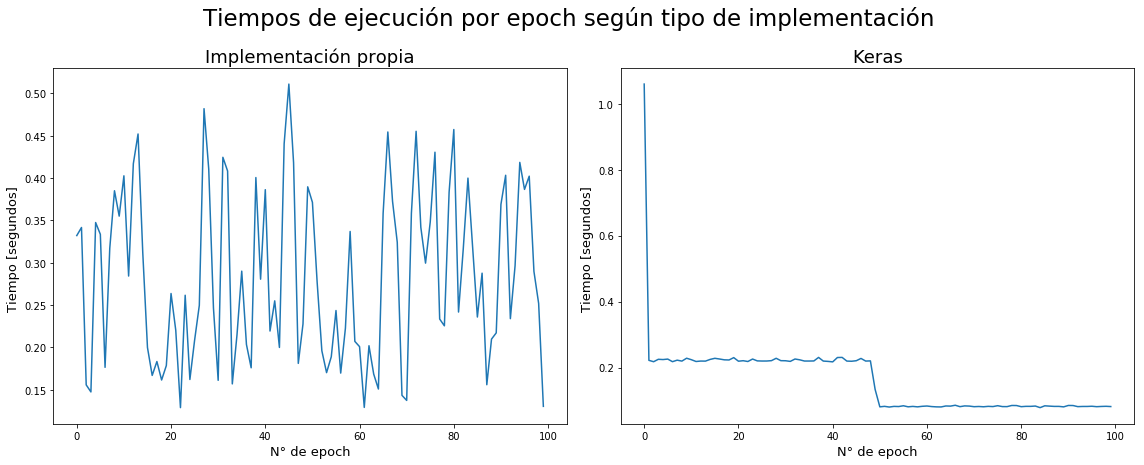

El tiempo total del entrenamiento con nuestra implementación fue de 28.36 segundos
El tiempo total del entrenamiento con keras fue de 15.97 segundos


In [17]:

plt.figure(1, figsize=(16,6))

plt.suptitle("Tiempos de ejecución por epoch según tipo de implementación \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(tiempo_propia_sc)), tiempo_propia_sc)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(tiempos_keras_sc.logs)), tiempos_keras_sc.logs)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)

plt.tight_layout() 
plt.show()

print("El tiempo total del entrenamiento con nuestra implementación fue de "+str(round(sum(tiempo_propia_sc),2))+" segundos")
print("El tiempo total del entrenamiento con keras fue de "+str(round(sum(tiempos_keras_sc.logs),2))+" segundos")


### Análisis:


**RELLENAR**

## Red con Sigmoid y Mean Squared Error

a) Defina, a través de la interfaz de keras, la arquitectura de la red, con las funciones de activación para comparar con la sección anterior.

In [18]:
model = Sequential()
model.add(Dense(32, input_dim=x_test.shape[1], activation="sigmoid"))
model.add(Dense(16, activation="sigmoid"))
model.add(Dense(3, activation="softmax"))

b) Defina, a través de la interfaz de keras, el optimizador de la red, en conjunto con la función de error, para poder comparar con la sección anterior.

In [19]:
model.compile(optimizer=SGD(lr=0.1),loss="mse", metrics=["accuracy"])

c) Entrene (ajuste) los pesos de la red definida mediante keras, reportando los mismos gráficos de la sección anterior para poder comparar. Si hay diferencias en la convergencia del algoritmo ¿A qué podría deverse? si hay una gran diferencia en los tiempos de entrenamiento ¿A qué podría deverse?

### Implementación con Keras

In [20]:
#Entrenamiento de red utilizando keras. Función activación:  sigmoide  Función de costo: median squared error
tiempos_keras_sm = TimingCallback()
keras_sm = model.fit(x_train, y_onehot_train, epochs=num_epochs, batch_size=1, verbose=0, callbacks=[tiempos_keras_sm])
accuracy_keras_sm = keras_sm.history['acc']
loss_keras_sm = keras_sm.history['loss']

### Implementación propia

In [21]:
nn_sm = RedNeuronal(4, [32, 16], 3, "sigmoid", "mse")
nn_sm.train(x_train, y_onehot_train, num_epochs, 0.1, verbose = False)
loss_propia_sm = nn_sm.log['loss']
accuracy_propia_sm = nn_sm.log['accuracy']
tiempo_propia_sm = nn_sm.log['tiempo']

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: mse
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.333022275242 - acc: 0.38


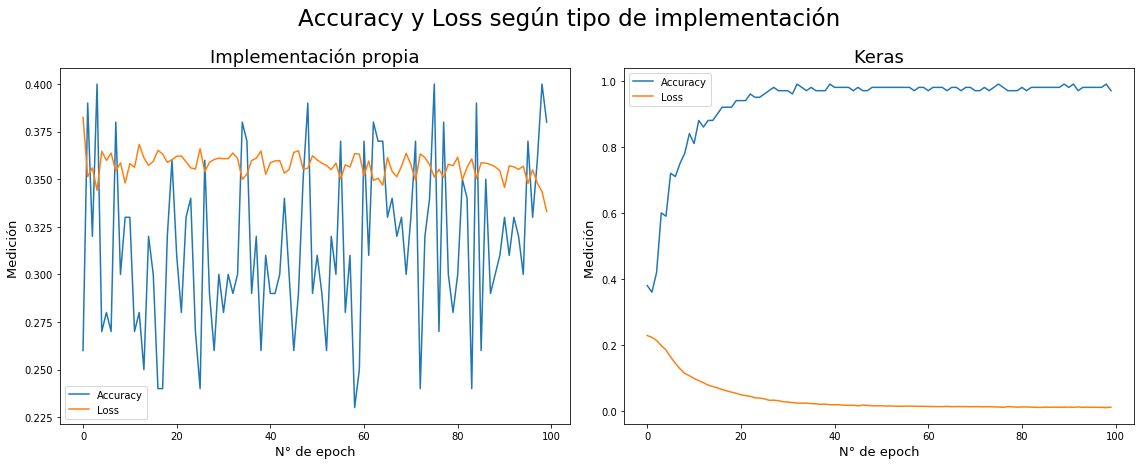



Accuracy Implementación Propia = 38.0%
Accuracy Keras = 97.0%


Loss Implementación Propia = 0.333
Loss Keras= 0.012


In [22]:
plt.figure(1, figsize=(16,6))
plt.suptitle("Accuracy y Loss según tipo de implementación \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(accuracy_propia_sm)), accuracy_propia_sm, label="Accuracy")
plt.plot(range(len(loss_propia_sm)), loss_propia_sm, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.legend()

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(accuracy_keras_sm)), accuracy_keras_sm, label="Accuracy")
plt.plot(range(len(loss_keras_sm)), loss_keras_sm, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.legend()

plt.tight_layout() 
plt.show()
print("\n")
print("Accuracy Implementación Propia = "+str(round(accuracy_propia_sm[-1]*100,2))+"%")
print("Accuracy Keras = "+str(round(accuracy_keras_sm[-1]*100,2))+"%")
print("\n")
print("Loss Implementación Propia = "+str(round(loss_propia_sm[-1],4)))
print("Loss Keras= "+str(round(loss_keras_sm[-1],4)))

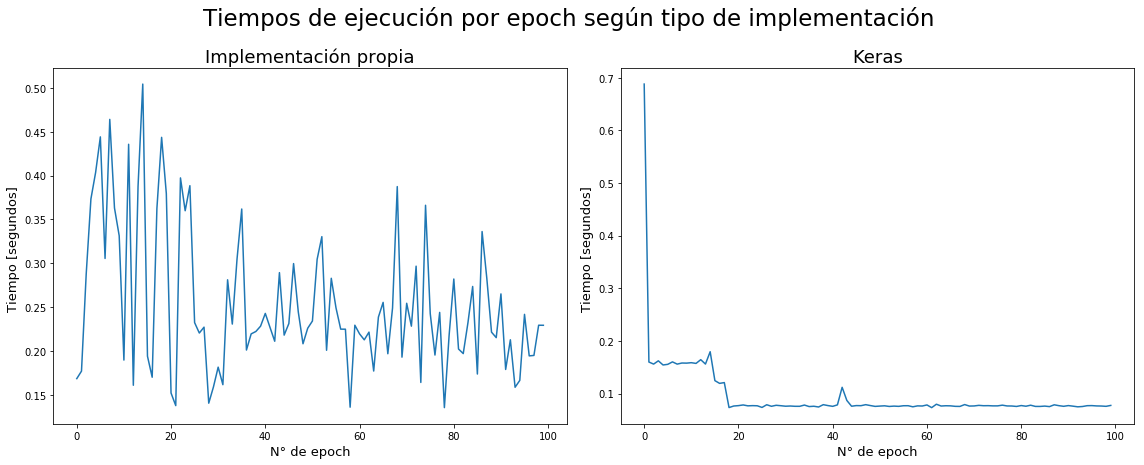

El tiempo total del entrenamiento con nuestra implementación fue de 25.35 segundos
El tiempo total del entrenamiento con keras fue de 9.6 segundos


In [23]:
plt.figure(1, figsize=(16,6))
plt.suptitle("Tiempos de ejecución por epoch según tipo de implementación \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(tiempo_propia_sm)), tiempo_propia_sm)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(tiempos_keras_sm.logs)), tiempos_keras_sm.logs)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)

plt.tight_layout() 
plt.show()

print("El tiempo total del entrenamiento con nuestra implementación fue de "+str(round(sum(tiempo_propia_sm),2))+" segundos")
print("El tiempo total del entrenamiento con keras fue de "+str(round(sum(tiempos_keras_sm.logs),2))+" segundos")


## Red con ReLU y Crossentropy

a) Defina, a través de la interfaz de keras, la arquitectura de la red, con las funciones de activación para comparar con la sección anterior.

In [24]:
model = Sequential()
model.add(Dense(32, input_dim=x_test.shape[1], activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(3, activation="softmax"))

b) Defina, a través de la interfaz de keras, el optimizador de la red, en conjunto con la función de error, para poder comparar con la sección anterior.

In [25]:
model.compile(optimizer=SGD(lr=0.1),loss="categorical_crossentropy", metrics=["accuracy"])

c) Entrene (ajuste) los pesos de la red definida mediante keras, reportando los mismos gráficos de la sección anterior para poder comparar. Si hay diferencias en la convergencia del algoritmo ¿A qué podría deverse? si hay una gran diferencia en los tiempos de entrenamiento ¿A qué podría deverse?

### Implementación con Keras

In [26]:
#Entrenamiento de red utilizando keras. Función activación:  relu  Función de costo: cross entropy
tiempos_keras_rc = TimingCallback()
keras_rc = model.fit(x_train, y_onehot_train, epochs=num_epochs, batch_size=1, verbose=0, callbacks=[tiempos_keras_rc])
accuracy_keras_rc = keras_sm.history['acc']
loss_keras_rc = keras_sm.history['loss']

### Implementación propia

In [27]:
nn_rc = RedNeuronal(4, [32,16], 3, "relu", "crossentropy")
nn_rc.train(x_train, y_onehot_train, num_epochs, 0.1, verbose = False)
loss_propia_rc = nn_rc.log['loss']
accuracy_propia_rc = nn_rc.log['accuracy']
tiempo_propia_rc = nn_rc.log['tiempo']

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: relu
	Función de costo: crossentropy
Comienza entrenamiento de red 


C:\Users\gonza\AppData\Local\conda\conda\envs\redesneuronales\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in subtract
C:\Users\gonza\AppData\Local\conda\conda\envs\redesneuronales\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in maximum
C:\Users\gonza\AppData\Local\conda\conda\envs\redesneuronales\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater


Resultado de training set de 100 epochs: loss nan - acc: 0.33


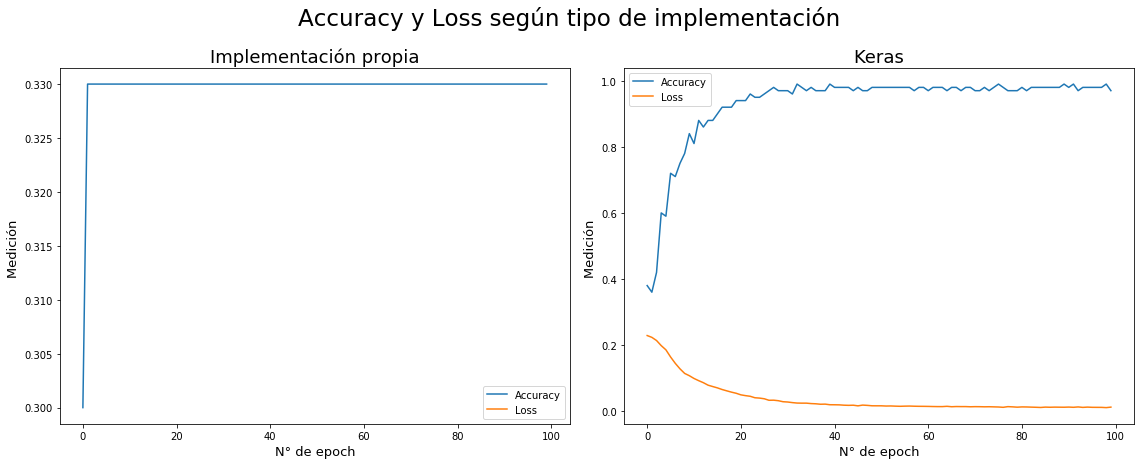



Accuracy Implementación Propia = 33.0%
Accuracy Keras = 97.0%


Loss Implementación Propia = nan
Loss Keras= 0.012


In [28]:
plt.figure(1, figsize=(16,6))
plt.suptitle("Accuracy y Loss según tipo de implementación \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(accuracy_propia_rc)), accuracy_propia_rc, label="Accuracy")
plt.plot(range(len(loss_propia_rc)), loss_propia_rc, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.legend()

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(accuracy_keras_rc)), accuracy_keras_rc, label="Accuracy")
plt.plot(range(len(loss_keras_rc)), loss_keras_rc, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.legend()

plt.tight_layout() 
plt.show()
print("\n")
print("Accuracy Implementación Propia = "+str(round(accuracy_propia_rc[-1]*100,2))+"%")
print("Accuracy Keras = "+str(round(accuracy_keras_rc[-1]*100,2))+"%")
print("\n")
print("Loss Implementación Propia = "+str(round(loss_propia_rc[-1],4)))
print("Loss Keras= "+str(round(loss_keras_rc[-1],4)))

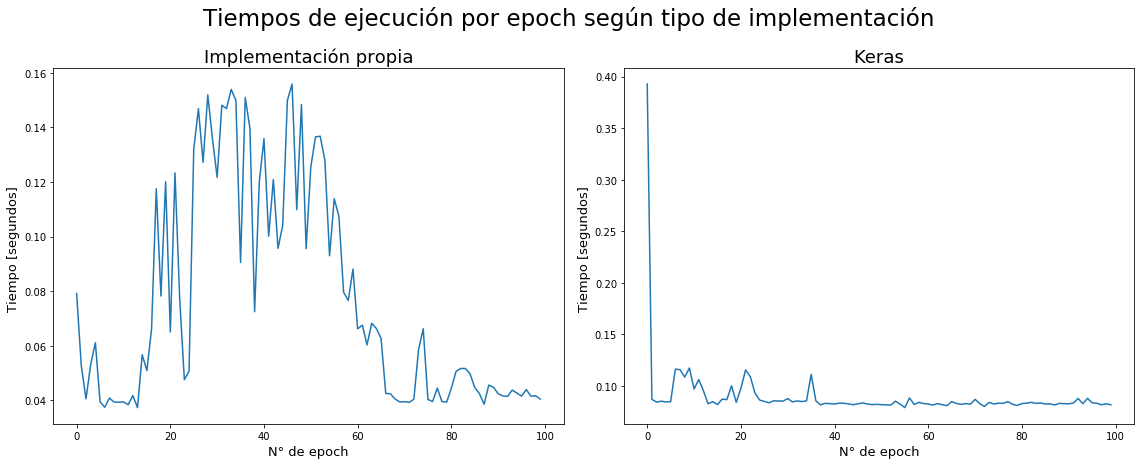

El tiempo total del entrenamiento con nuestra implementación fue de 7.67 segundos
El tiempo total del entrenamiento con keras fue de 8.97 segundos


In [29]:
plt.figure(1, figsize=(16,6))
plt.suptitle("Tiempos de ejecución por epoch según tipo de implementación \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(tiempo_propia_rc)), tiempo_propia_rc)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(tiempos_keras_rc.logs)), tiempos_keras_rc.logs)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)

plt.tight_layout() 
plt.show()

print("El tiempo total del entrenamiento con nuestra implementación fue de "+str(round(sum(tiempo_propia_rc),2))+" segundos")
print("El tiempo total del entrenamiento con keras fue de "+str(round(sum(tiempos_keras_rc.logs),2))+" segundos")


## Red con ReLU y Mean Squared Error

a) Defina, a través de la interfaz de keras, la arquitectura de la red, con las funciones de activación para comparar con la sección anterior.

In [30]:
model = Sequential()
model.add(Dense(32, input_dim=x_test.shape[1], activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(3, activation="softmax"))

b) Defina, a través de la interfaz de keras, el optimizador de la red, en conjunto con la función de error, para poder comparar con la sección anterior.

In [31]:
model.compile(optimizer=SGD(lr=0.1),loss="mse", metrics=["accuracy"])

c) Entrene (ajuste) los pesos de la red definida mediante keras, reportando los mismos gráficos de la sección anterior para poder comparar. Si hay diferencias en la convergencia del algoritmo ¿A qué podría deverse? si hay una gran diferencia en los tiempos de entrenamiento ¿A qué podría deverse?

### Implementación con Keras

In [32]:
#Entrenamiento de red utilizando keras. Función activación:  relu  Función de costo: mse
tiempos_keras_rm = TimingCallback()
keras_rm = model.fit(x_train, y_onehot_train, epochs=num_epochs, batch_size=1, verbose=0, callbacks=[tiempos_keras_rm])
accuracy_keras_rm = keras_sm.history['acc']
loss_keras_rm = keras_sm.history['loss']

### Implementación Propia

In [33]:
nn_rm = RedNeuronal(4, [32,16], 3, "relu", "mse")
nn_rm.train(x_train, y_onehot_train, num_epochs, 0.1, verbose = False)
loss_propia_rm = nn_rm.log['loss']
accuracy_propia_rm = nn_rm.log['accuracy']
tiempo_propia_rm = nn_rm.log['tiempo']

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: relu
	Función de costo: mse
Comienza entrenamiento de red 
Resultado de training set de 100 epochs: loss 0.66 - acc: 0.34


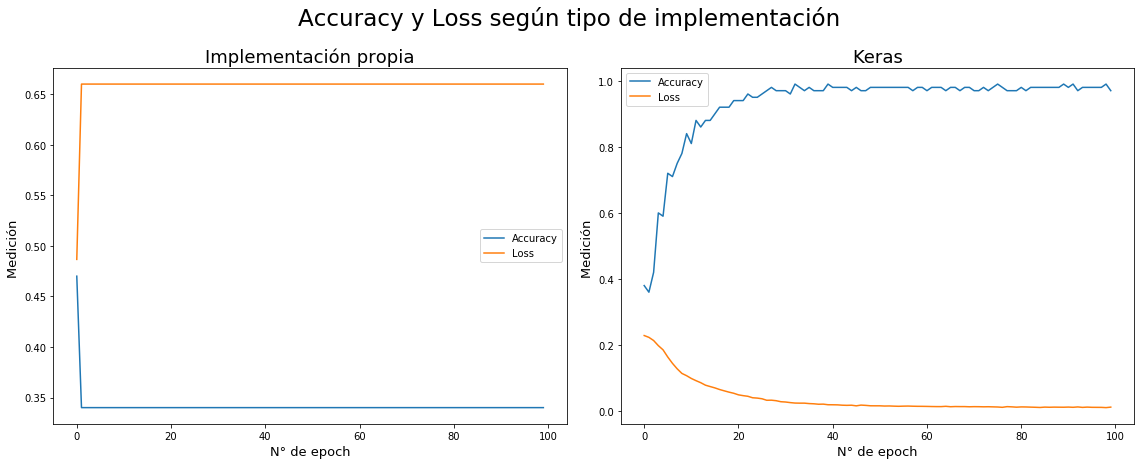



Accuracy Implementación Propia = 34.0%
Accuracy Keras = 97.0%


Loss Implementación Propia = 0.66
Loss Keras= 0.012


In [34]:
plt.figure(1, figsize=(16,6))
plt.suptitle("Accuracy y Loss según tipo de implementación \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(accuracy_propia_rm)), accuracy_propia_rm, label="Accuracy")
plt.plot(range(len(loss_propia_rm)), loss_propia_rm, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.legend()

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(accuracy_keras_rm)), accuracy_keras_rm, label="Accuracy")
plt.plot(range(len(loss_keras_rm)), loss_keras_rm, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.legend()

plt.tight_layout() 
plt.show()
print("\n")
print("Accuracy Implementación Propia = "+str(round(accuracy_propia_rm[-1]*100,2))+"%")
print("Accuracy Keras = "+str(round(accuracy_keras_rm[-1]*100,2))+"%")
print("\n")
print("Loss Implementación Propia = "+str(round(loss_propia_rm[-1],4)))
print("Loss Keras= "+str(round(loss_keras_rm[-1],4)))

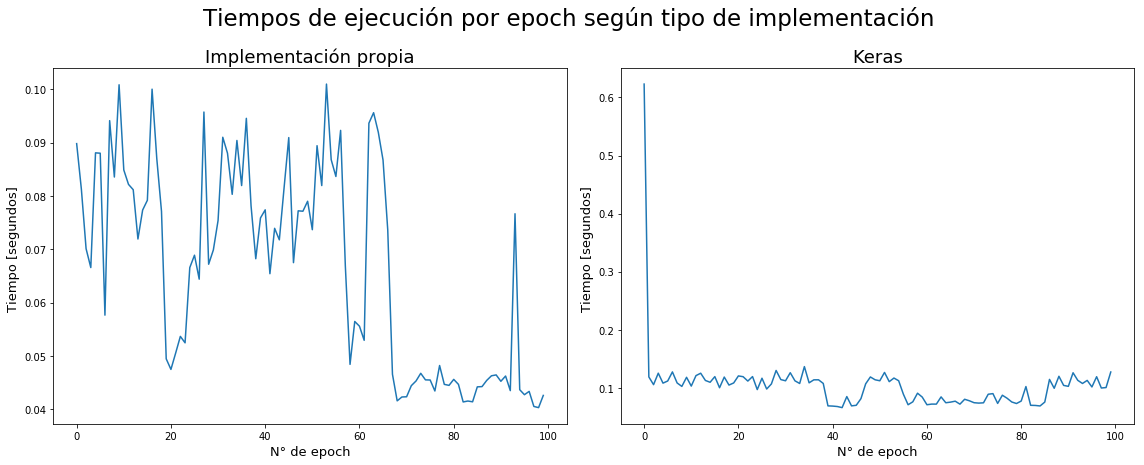

El tiempo total del entrenamiento con nuestra implementación fue de 6.65 segundos
El tiempo total del entrenamiento con keras fue de 10.4 segundos


In [35]:
plt.figure(1, figsize=(16,6))
plt.suptitle("Tiempos de ejecución por epoch según tipo de implementación \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Implementación propia",fontsize=18)
plt.plot(range(len(tiempo_propia_rm)), tiempo_propia_rm)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)

plt.subplot(122)
plt.title("Keras",fontsize=18)
plt.plot(range(len(tiempos_keras_rm.logs)), tiempos_keras_rm.logs)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)

plt.tight_layout() 
plt.show()

print("El tiempo total del entrenamiento con nuestra implementación fue de "+str(round(sum(tiempo_propia_rm),2))+" segundos")
print("El tiempo total del entrenamiento con keras fue de "+str(round(sum(tiempos_keras_rm.logs),2))+" segundos")


<a id="tercero"></a>
### 3. Verificación numérica del gradiente para una componente

En esta sección deberá verificar numéricamente el gradiente para los parámetros del modelo (que en este caso son los pesos de la red), que hasta ahora a definido de manera analítica en su programa, por ejemplo la derivada de $x^2$ es $2x$. Ahora deberá verificar estos cálculos usando la definición de gradiente.

$$ \nabla_{w} Loss = \lim_{\epsilon \rightarrow 0} \frac{Loss(w+ \epsilon)-Loss(w)}{\epsilon} $$

Debido a que el *forward propagation* es relativamente fácil de implementar, se puede confiar en que se realizó de manera correcta, por lo que el cómputo del error (*loss*) debería ser correcto. Esto significa que podemos verificar el gradiente o la derivada analítica del error $\frac{\partial Loss}{\partial w}$ comprobando que el resultado obtenido es similar (dentro de una tolerancia numérica, por ejemplo $10^6$) al valor que obtenemos aplicando la fórmula anterior. Naturalmente interpretaremos $\lim_{\epsilon \rightarrow 0}$ como un valor "*suficientemente pequeño*" de $\epsilon$.


> a) Para un peso escogido aleatoriamente entre la primera capa de la red (*input*) y la primera capa oculta, calcule el valor del gradiente de la función de error para ambas funciones utilizadas (ayúdese mediante las funciones de *backward pass* implementadas anteriormente), luego compare y verifique con el valor numérico del gradiente mediante el procedimiento explicado anteriormente.



In [38]:
#cost_func: crossentropy o  mse
#e: epsilon
#w: peso(ij)


def crossentropy(self, prediccion, esperado, epsilon=1e-12): #El epsilon evita log(0)
    prediccion = np.clip(prediccion, epsilon, 1. - epsilon)
    N = prediccion.shape[0]
    ce = -np.sum(np.sum(esperado*np.log(prediccion+epsilon)))/N
    return ce

def crossentropy_derivative(self, prediccion, esperado, squash_prime, vector_z):
    return prediccion-esperado

def mse(self, prediccion, esperado):
    return 0.5*np.dot(prediccion-esperado, prediccion-esperado)

def mse_derivative(self, prediccion, esperado, squash_prime, vector_z):
    return (prediccion-esperado) * squash_prime(vector_z)
    


> b) Vuelva a verificar el valor del gradiente para otros dos pesos escodigos aleatoriamente en la primera operación de la red. Compare y concluya.

<a id="cuarto"></a>
### 4. Implementar *momentum* como variante

En esta sección se construyó, sin usar librerı́as, excepto eventualmente *numpy* para la implementación de operaciones básicas de algebra lineal, una variante del programa definido anteriormente ([sección 1](#primero)) que entrena la red utilizando *momentum* clásico.

$$ v^{(t+1)} \leftarrow \mu v^{(t)} - \eta \nabla_{w^{(t)}} Loss \\
w^{(t+1)} \leftarrow w^{(t)} + v^{(t+1)}
$$


> Más información: *Sutskever, I., Martens, J., Dahl, G., & Hinton, G. (2013, February). On the importance of initialization and momentum in deep learning. In International conference on machine learning (pp. 1139-1147).*




Para responder esta pregunta, hay que considerar que en redes neuronales se ocupan distintas estrategias de optimización (como *Gradient descent* o *Stochastic gradient descent*) con el fin de minimizar el error de la función objetivo utilizada y así alcanzar el mínimo global. En un mundo ideal, el algoritmo siempre alcanzaría el mínimo global. 
<figure>
    <img src="https://qph.ec.quoracdn.net/main-qimg-03849f4b36ffe0d8bdf51b058c316ec4">
</figure>    

Sin embargo, en el mundo real las superficies son más complejas por lo que podría estár compuesta de varios mínimos locales. 
<img src="https://qph.ec.quoracdn.net/main-qimg-834da2a61df256c91ba57827da985638">
En este caso, un algoritmo como GD y SGD podría perfectamente atacarse en un mínimo local haciendo creer que se ha alcanzado el mínimo global. Para evitar esta situación, se utiliza el término de momentum $\mu$ en la función objetivo, este valor varía entre $0$ y $1$ y permite incrementar el tamaño de los pasos dados hacia el punto mínimo tratando de saltar desde un mínimo local. 

**¿Qué valor de $\mu$ debe escogerse?**  Un valor alto de momentum implicará idealmente que la convergencia suceda de manera rápida. Además el valor de $\mu$ debe ser mayor al del *learning rate* $\eta$, ya que si $\mu$ y $\eta$ son igualmente altos, probablemente se esquivará el punto mínimo global a pasos agigantados. Un pequeño valor de $\mu$ no permitiría evitar los mínimos locales y además retardaría el *training* del sistema. **El valor de momentum $\mu$ utilizado fue de $0.9$ mientras que el *learning rate* $\eta$ tuvo un valor de $0.1$**

Hay que señalar también que momentum permite suavizar las variaciones en casos donde hay un constante cambio de dirección. Por último, el valor de momentum puede ser escogido a prueba y error o utilizando *cross validation*

Usando backpropagation con momentum en una red con $n$ diferentes pesos $W_k$, la íesima corrección para el peso $W_k$ está dada por: <br/>

$$ \Delta W_k^{(i)} = \eta \frac{\partial E}{\partial W_k} + \mu \Delta W_k^{(i-1)}$$

donde $\frac{\partial E }{\partial W_k}$ representa a la variación del costo con respecto al peso $W_k$. Además $\eta$ representa  el *learning rate* y $\mu$ el momentum. *Para mayor información sobre la fórmula utilizada se puede consultar el siguiente documento: [Fast Learning Algorithms](http://page.mi.fu-berlin.de/rojas/neural/chapter/K8.pdf)* *(pág. 187)*

Esta modificación fue aplicada al codigo presente en la [sección 1](#primero). Dado lo anterior, fue posible comparar la evolución de la función de activación y de costo para dos redes neuronales (una con y otra sin momentum).





#### Parámetros para probar implementaciones

In [39]:
tiempos_keras_sc = TimingCallback()
num_epochs = 40


#### Red Neuronal con Momentum 

In [40]:
nn_sc_m = RedNeuronal(4, [32,16], 3, "sigmoid", "crossentropy")
nn_sc_m.train(x_train, y_onehot_train, num_epochs, 0.1, momentum=0.9)
loss_sc_m = nn_sc_m.log['loss']
accuracy_sc_m = nn_sc_m.log['accuracy']
tiempo_sc_m = nn_sc_m.log['tiempo']

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: crossentropy
Comienza entrenamiento de red con momentum 0.9
Resultado de training set de 40 epochs: loss 0.0785883286161 - acc: 0.91


#### Red Neuronal sin Momentum

In [41]:
nn_sc = RedNeuronal(4, [32,16], 3, "sigmoid", "crossentropy")
nn_sc.train(x_train, y_onehot_train, num_epochs, 0.1, verbose = False)
loss_sc = nn_sc.log['loss']
accuracy_sc = nn_sc.log['accuracy']
tiempo_sc = nn_sc.log['tiempo']

Red Neuronal creada
	Capas: 4 [32, 16] 3
	Activación interna: sigmoid
	Función de costo: crossentropy
Comienza entrenamiento de red 
Resultado de training set de 40 epochs: loss 0.0603992319476 - acc: 0.93


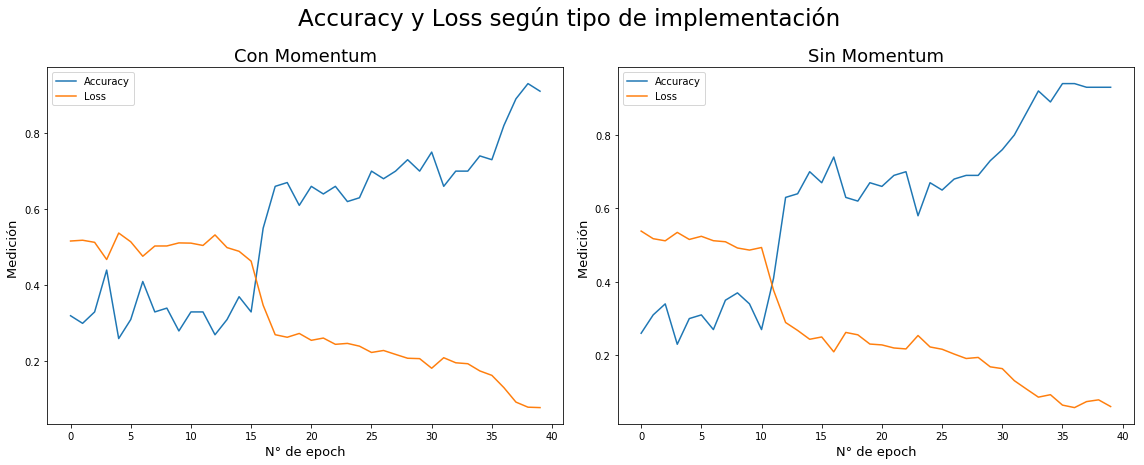



Accuracy con Momentum = 91.0%
Accuracy sin Momentum = 93.0%


Loss con Momentum = 0.0786
Loss sin Momentum = 0.0604


In [42]:
plt.figure(1, figsize=(16,6))
plt.suptitle("Accuracy y Loss según tipo de implementación \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Con Momentum",fontsize=18)
plt.plot(range(len(accuracy_sc_m)), accuracy_sc_m, label="Accuracy")
plt.plot(range(len(loss_sc_m)), loss_sc_m, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.legend()

plt.subplot(122)
plt.title("Sin Momentum",fontsize=18)
plt.plot(range(len(accuracy_sc)), accuracy_sc, label="Accuracy")
plt.plot(range(len(loss_sc)), loss_sc, label="Loss")
plt.ylabel('Medición ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)
plt.legend()

plt.tight_layout() 
plt.show()
print("\n")
print("Accuracy con Momentum = "+str(round(accuracy_sc_m[-1]*100,2))+"%")
print("Accuracy sin Momentum = "+str(round(accuracy_sc[-1]*100,2))+"%")
print("\n")
print("Loss con Momentum = "+str(round(loss_sc_m[-1],4)))
print("Loss sin Momentum = "+str(round(loss_sc[-1],4)))

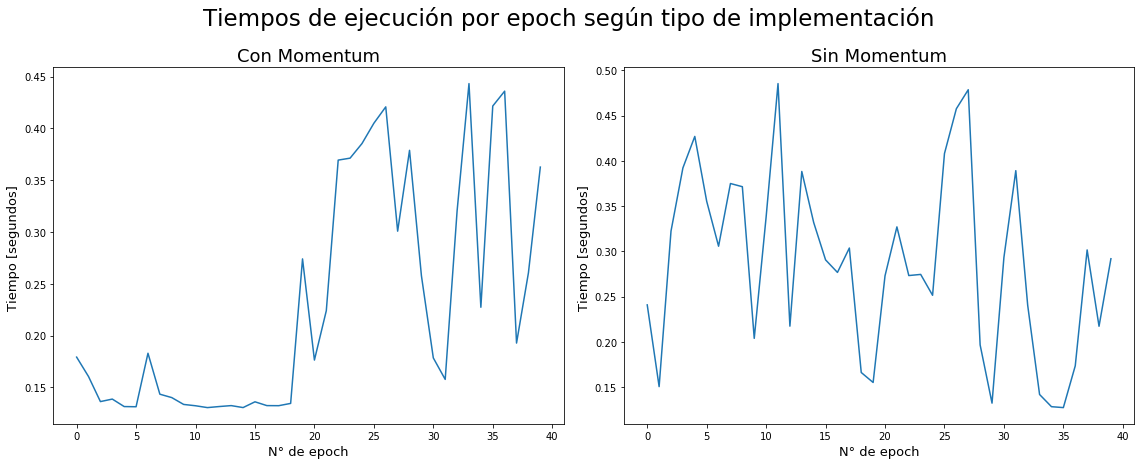

Tiempo total de red con momentum: 9.23 segundos
Tiempo total de red sin momentum: 11.47 segundos


In [43]:
plt.figure(1, figsize=(16,6))
plt.suptitle("Tiempos de ejecución por epoch según tipo de implementación \n \n", fontsize=23, y=1.07)

plt.subplot(121)
plt.title("Con Momentum",fontsize=18)
plt.plot(range(len(tiempo_sc_m)), tiempo_sc_m)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)

plt.subplot(122)
plt.title("Sin Momentum",fontsize=18)
plt.plot(range(len(tiempo_sc)), tiempo_sc)
plt.ylabel('Tiempo [segundos] ', fontsize=13)
plt.xlabel('N° de epoch', fontsize=13)

plt.tight_layout() 
plt.show()

print("Tiempo total de red con momentum: "+str(round(sum(tiempo_sc_m),2))+" segundos")
print("Tiempo total de red sin momentum: "+str(round(sum(tiempo_sc),2))+" segundos")


# ANALIZAR
Los resultados anteriores permitieron determinar que ambas redes funcionan para el mismo problema de clasificación, sin emmargo, podemos decir que:


**analizar**
Demuestre que su programa funciona en el mismo problema de clasificación presentado anteriormente, para esto, además deberá construir un gráfico de la función de error o pérdida (*loss*) *vs* el número de *epochs* y comentar/analizar la convergencia. ¿Es una mejora significativa? 


## Referencias

* Momentum: https://www.willamette.edu/~gorr/classes/cs449/momrate.html
* Momentum: https://distill.pub/2017/momentum/
* Formula Momentum: https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx